In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

## Data loading

In [2]:
data = pd.read_csv("krankenkasse-mit-pbf.csv", sep = ";", names = ['age', 'sex', 'bmi', 'children', 'smoker', 'canton', "pbf", 'charges'])
data = data.iloc[1:]

data['charges'] = data['charges'].str.replace("’", "").apply(pd.to_numeric)
data['pbf'] = data['pbf'].apply(pd.to_numeric)
data['bmi'] = data['bmi'].apply(pd.to_numeric)
data['age'] = data['age'].apply(pd.to_numeric)
data['children'] = data['children'].apply(pd.to_numeric)

# Encode categorical variables.
data["sex"] = pd.factorize(data['sex'])[0]
data["smoker"] = pd.factorize(data['smoker'])[0]

data['canton'] = pd.factorize(data['canton'])[0]

# Remove encoded categorical variables.

# 1 record with negative percentage of body fat.
data = data[data["pbf"]>0]

# Divide the charges into categories. Is there a more objective way to determine the categories? K-clustering?
bins = [0, 5000, 10000, 20000, 100000]
bin_labels = [0, 1, 2, 3]
data["charges_level"] = pd.cut(data["charges"], bins=bins, labels=bin_labels, include_lowest=True)


data.sort_values(by='charges', ascending=False, na_position='first')
data = data.dropna()

### Data without outliers:

In [3]:
#index are not correct, don't know why, removed entries manually
children_outliers_to_del = data[(data['age'] <= 21) & (data['children'] == 5)].index.values - 1

for i in children_outliers_to_del:
    print(i)

#when these are removed, the score is worse by .10 for some reason but the mean absolute error drops by 60 points
data2 = data.drop(data.index[[32, 165, 983]])
data2[(data2['age'] <= 21) & (data2['children'] == 5)]

charges_outliers_to_del = data2[(data['charges'] >= 59000)].index.values - 1
for i in charges_outliers_to_del:
    print(i)

data_no_outliers = data2.drop(data.index[[542]])

data_no_outliers[(data['charges'] >= 59000)]
data_no_outliers

32
166
984
543


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,age,sex,bmi,children,smoker,canton,pbf,charges,charges_level
1,19,0,24.720,0,0,0,35.94,4253,0
2,18,1,29.416,1,1,1,26.86,2494,0
3,28,1,28.800,3,1,1,26.92,3138,0
4,33,1,20.564,0,1,2,7.98,1553,0
5,32,1,25.504,0,1,2,21.84,2768,0
...,...,...,...,...,...,...,...,...,...
1334,50,1,27.176,3,1,2,23.02,5767,1
1335,18,0,27.936,0,1,3,42.18,2547,0
1336,18,0,31.880,0,1,1,49.59,3026,0
1337,21,0,23.040,0,1,0,31.18,2208,0


## Implementation of the ridge regression functions

In [4]:
from sklearn.base import BaseEstimator

class RidgeRegression(BaseEstimator):
    
    def __init__(self, opt_method='gd', alpha=1., eta=0.01, maxsteps=100, eps=0.00000001):
        '''Implements a Ridge Regression estimator.
        
        Arguments
        ---------
        alpha:      Regularization proportionality factor. Larger values
                    correspond with stronger regularization.
        opt_method: Optimization method to choose for the cost function.
                    Can be either 'gd' (Gradient Descent) or 'neq'.
        maxsteps:   Maximum number of Gradient Descent steps to take.
        eps:        Epsilon, length of gradient to be reached with Gradient
                    Descent.
        eta:        Fixed step lenght to take at each gradient descent
                    iteration.
        '''
        # parameters
        self.alpha = alpha
        self.opt_method = opt_method
        self.maxsteps = maxsteps
        self.eps = eps
        self.eta = eta
        # attributes
        # model coefficients
        self.beta_ = None
        # values of cost function along gradient descent iterations
        self.costs_ = []  
        self.bins = [0, 5000, 10000, 20000, 100000]
        
    def fit(self,X,y):
        if(self.opt_method == "neq"):
            type(X)
            return(self.normalequation(X,y))
        else:
            raise Exception("No available optimization method was chosen.")
            
    def normalequation(self,X,y):
        '''Computes the coefficients of the ridge regression cost function
        using the normalequation.
        '''
        
        XX = np.zeros((len(X),X.shape[1]+1))
        XX[:,0] = np.ones(len(X))

        XX[:,1:] = X
        
        #identity matrix with full range
        identity = np.identity(XX.shape[1])
        identity[0,:] = np.zeros(identity.shape[0])
        
        self.beta_ = np.linalg.inv(XX.T @ XX + self.alpha * identity) @ XX.T @ y
        
        return(self.beta_)
    
    @staticmethod 
    def costfunction(beta,X,y,alpha):
        '''Computes and returns the value of the ridge regression cost function.
        '''
        
        cost = np.sum((y - beta[0] + np.dot(X, beta[1:])**2) + alpha * np.sum(beta.T @ beta))
        
        return cost
    
    def predict(self,X):
        '''Computes the predictions of the current model.
            takes in a Xx8 matrix and spits out its respective prediction
        '''
        
        if(self.beta_ is not None):
            predictions = self.beta_[0] + np.dot(X, self.beta_[1:])

            return predictions
        
        raise Exception("Model coefficient haven't been calculated yet. Please call the specific functions to calculate the coefficients.")
        
    @staticmethod
    def score(y,y_hat):
        '''Returns R^2 for given input/output data given the model
        coefficients. 1 - (sum of squares of residuals / total sum of squares) | sum of squares = sum of (yi - mean(y))^2
        '''
        
        ss_res = np.sum((y - y_hat)**2)
                        
        ss_tot = np.sum((y-np.mean(y))**2)
        
        score = 1-(ss_res/ss_tot)
        
        return score
    
    @staticmethod
    def mae(y, y_hat):
        mae =  (1 / len(y)) * np.sum(abs(y-y_hat))
        return mae
    
    @staticmethod
    def scoreLevels(y, y_hat):
        mae =  (1 / len(y)) * np.sum(abs(y-y_hat))
        return mae

In [31]:
from sklearn.model_selection import train_test_split

labels = np.array(data['charges'])
# The data we want to split = 'input'
input = data.drop('charges', axis=1).drop('charges_level', axis=1).drop('bmi', axis = 1)
print(input)

# The argument for the split function has to be an array
input = np.array(input)

train_input, test_input, train_labels, test_labels = \
    train_test_split(input, labels, test_size = 0.2, random_state = 42) 

      age  sex  children  smoker  canton    pbf
1      19    0         0       0       0  35.94
2      18    1         1       1       1  26.86
3      28    1         3       1       1  26.92
4      33    1         0       1       2   7.98
5      32    1         0       1       2  21.84
...   ...  ...       ...     ...     ...    ...
1334   50    1         3       1       2  23.02
1335   18    0         0       1       3  42.18
1336   18    0         0       1       1  49.59
1337   21    0         0       1       0  31.18
1338   61    0         0       0       2  38.63

[1337 rows x 6 columns]


In [32]:
##instantiate regressor
RidgeRegressor = RidgeRegression(opt_method='neq', alpha = 34.04340434)
ridge1 = RidgeRegressor.fit(train_input, train_labels) 

print("Ridge Regressors:", ridge1)

#predict function
test = test_input
print("Input Data: ", test[10:16:])
print("Real Charges: ", test_labels[10:16:])
predics = RidgeRegressor.predict(test)
print("Predicted Charges: ", predics[10:16:])

Ridge Regressors: [-6822.68760202   156.40772748  4052.22165001   155.08668993
 -6200.11196671   441.46187453   295.50562537]
Input Data:  [[57.    0.    0.    1.    3.   32.38]
 [61.    0.    0.    1.    2.   40.36]
 [32.    1.    1.    0.    3.   27.74]
 [61.    0.    0.    1.    0.   60.4 ]
 [35.    0.    2.    1.    3.   51.17]
 [44.    0.    2.    1.    1.   29.54]]
Real Charges:  [ 4126  7775 10859 17131  8304  3137]
Predicted Charges:  [ 6785.29867068  9327.60259654 11911.37968863 14366.61157993
  9207.05274674  3340.01186821]


In [33]:
#score function
score = RidgeRegressor.score(test_labels, predics)
print("Score:", format(score, 'f'))
mae = RidgeRegressor.mae(test_labels, predics)
print("Mean Absolute Error:", format(mae, "f"))

Score: 0.660177
Mean Absolute Error: 2205.981574


Dropping BMI does not have much of a difference actually.

##### By the way, the sklearn prints the same results for the regression

In [34]:
#SKLEARN?
from sklearn.linear_model import Ridge
# define model
model = Ridge(alpha=1.0)
# fit model
model.fit(train_input, train_labels)

RidgeRegressor = Ridge(alpha=1.0)
RidgeRegressor.fit(train_input, train_labels)

predics = RidgeRegressor.predict(test_input)

print("sklearn vs own formula prediction comparison:", model.predict(test_input) == predics)

sklearn vs own formula prediction comparison: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  Tru

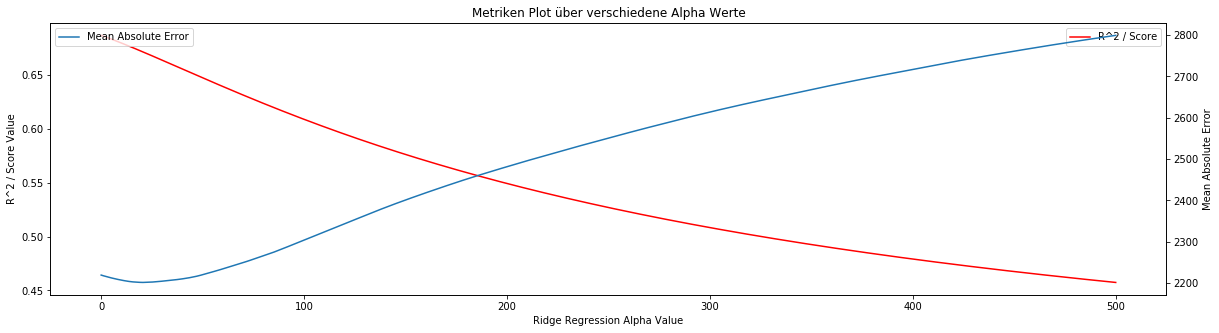

R^2/Score max value: 0.6864468709970091
Alpha value for R^2/Score max value: 0.0

Mean Absolute Error min value: 2200.980306510447
Alpha value for Mean Absolute Error min value: 20.05200520052005

Mean Absolute Error where R^2 is max 2218.8575800337408
R^2/Score value where MAE is minimum: 0.6857716370341155


In [35]:
##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 500, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input, train_labels)

    predics = RidgeRegressor.predict(test_input)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

##### Standardizing data seems to reduce MAE and only marginally decrease the score by 0.02

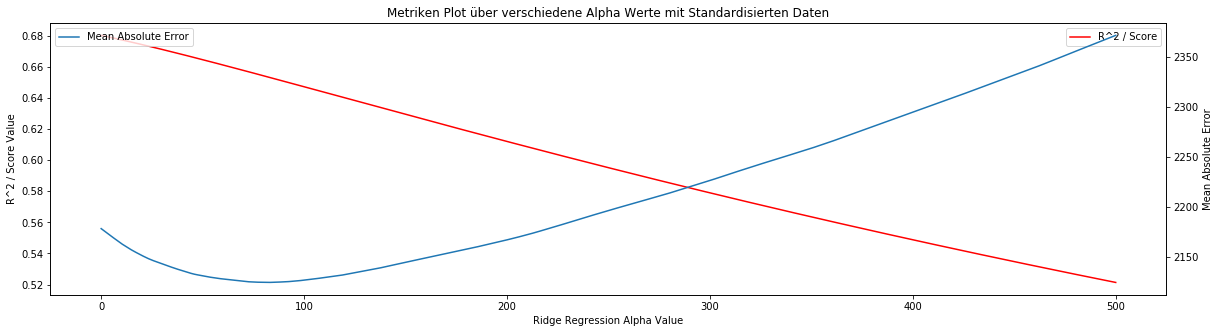

R^2/Score max value: 0.6803384645966595
Alpha value for R^2/Score max value: 0.0

Mean Absolute Error min value: 2124.5474257408105
Alpha value for Mean Absolute Error min value: 82.25822582258225

Mean Absolute Error where R^2 is max 2178.3731059279608
R^2/Score value where MAE is minimum: 0.6791830298606907


In [36]:
train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 500, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte mit Standardisierten Daten")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

[3.58185088 3.29063819 3.2928695  ... 3.9037892  3.43977686 3.65402918]


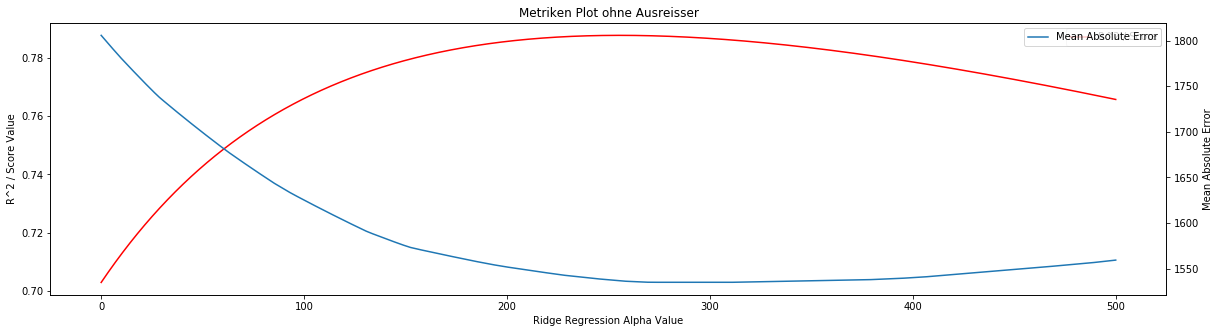

R^2/Score max value: 0.7877720192332744
Alpha value for R^2/Score max value: 255.5255525552555

Mean Absolute Error min value: 1534.797279208472
Alpha value for Mean Absolute Error min value: 307.3807380738074

Mean Absolute Error where R^2 is max 1773.7562976439215
R^2/Score value where MAE is minimum: 0.7174978681246593


In [37]:
labels = np.array(data_no_outliers['charges'])
# The data we want to split = 'input'
input = data_no_outliers.drop('charges', axis=1).drop('charges_level', axis=1).drop('bmi', axis = 1)

# The argument for the split function has to be an array
input_list = list(input.columns)
input = np.array(input)

print(np.log(input[:,5]))

train_input, test_input, train_labels, test_labels = \
    train_test_split(input, labels, test_size = 0.1, random_state = 42) 

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 500, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

##### Without outliers we can bring down the mean absolute error by 200 and the R^2/Score finally gets bigger. I don't know why the R^2/Score only rises when removing outliers. The max value of the score and the min value of the MAE occur at similar alpha values. 

##### What does it look like when we differentiate between smoker and non smoker and do for each one a seperate regression? The following example uses only smokers and the MAE is 1000 but with non smokers the MAE is 3000...

In [38]:
data_smoker = data_no_outliers[data_no_outliers['smoker'] == 1]
data_non_smoker = data_no_outliers[data_no_outliers['smoker'] == 0]
print(type(data_non_smoker), type(data_no_outliers))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


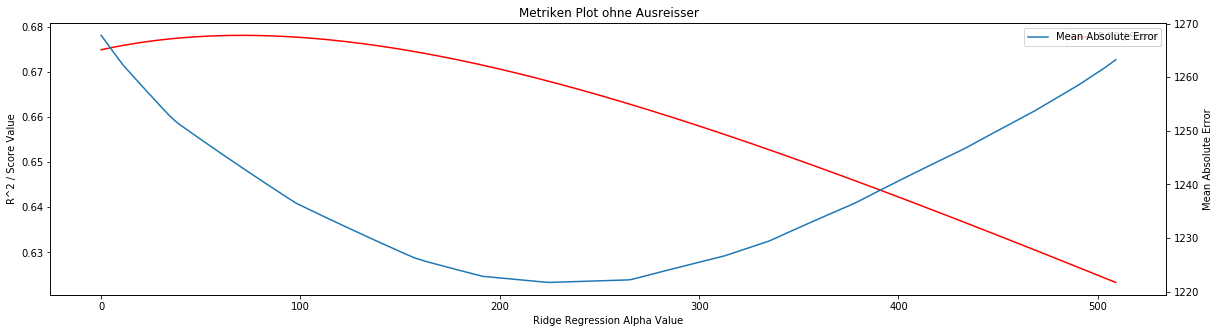

R^2/Score max value: 0.6781040022412468
Alpha value for R^2/Score max value: 70.65626562656266

Mean Absolute Error min value: 1221.7109076394504
Alpha value for Mean Absolute Error min value: 224.28782878287828

Mean Absolute Error where R^2 is max 1265.9636094278776
R^2/Score value where MAE is minimum: 0.6759068005210382


In [39]:
labels = np.array(data_smoker['charges'])
# The data we want to split = 'input'
input = data_smoker.drop('charges', axis=1).drop('charges_level', axis=1).drop('bmi', axis = 1).drop('smoker', axis = 1).drop('sex', axis = 1)

# The argument for the split function has to be an array
input_list = list(input.columns)
input = np.array(input)

train_input, test_input, train_labels, test_labels = \
    train_test_split(input, labels, test_size = 0.1, random_state = 42) 

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 509, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)
    
    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

##### In the following exmaple i tried taking the logarithm of age and pbf to see if it improves the model

1       19.0
2       18.0
3       28.0
4       33.0
5       32.0
        ... 
1334    50.0
1335    18.0
1336    18.0
1337    21.0
1338    61.0
Name: age, Length: 1333, dtype: float64


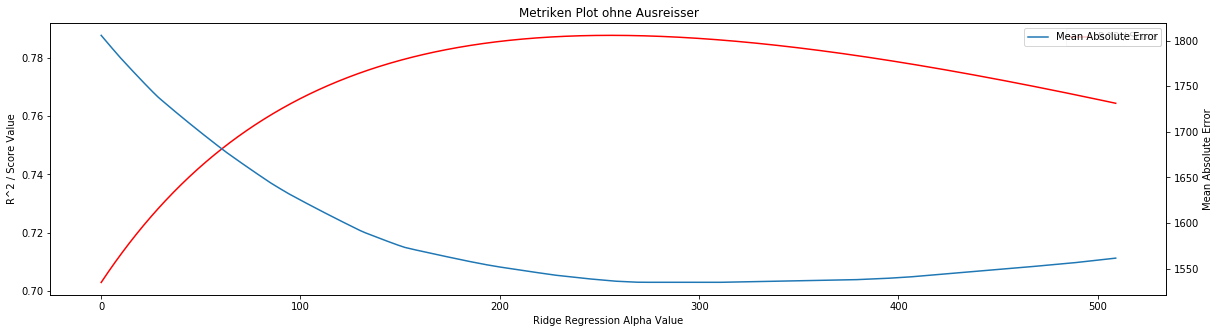

R^2/Score max value: 0.7877719836876678
Alpha value for R^2/Score max value: 255.26426426426423

Mean Absolute Error min value: 1534.7983329018991
Alpha value for Mean Absolute Error min value: 307.2342342342342

Mean Absolute Error where R^2 is max 1591.715933884341
R^2/Score value where MAE is minimum: 0.7803384717968807


In [40]:
labels = np.array(data_no_outliers['charges'])
# The data we want to split = 'input'
data_no_outliers_log = data_no_outliers.copy()
print(data_no_outliers_log["age"].astype('float64'))
input = data_no_outliers_log.drop('charges', axis=1).drop('charges_level', axis=1).drop('bmi', axis = 1)

# The argument for the split function has to be an array
input_list = list(input.columns)
input = np.array(input)

alphaRange = np.linspace(0, 509, 1000)

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.1, random_state = 42) 
train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)
##instantiate regressor
scoreArray = []
maeArray = []
for j in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = j)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)

plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

### PCA:

In the following PCA example, age, smoker Y/N, bmi and pbf were orthogonalized and in the dataframe that was used for the regression, the orthogonalized versions of those features were used instead of the original ones. Furthermore, to match our marketing strategy, biological sex was dropped all together as a feature. Dropping this feature resulted in a slightly better version of the model.

#### TODO: Include sex

In [41]:
data_no_outliers

,age,sex,bmi,children,smoker,canton,pbf,charges,charges_level
1,19,0,24.720,0,0,0,35.94,4253,0
2,18,1,29.416,1,1,1,26.86,2494,0
3,28,1,28.800,3,1,1,26.92,3138,0
4,33,1,20.564,0,1,2,7.98,1553,0
5,32,1,25.504,0,1,2,21.84,2768,0
...,...,...,...,...,...,...,...,...,...
1334,50,1,27.176,3,1,2,23.02,5767,1
1335,18,0,27.936,0,1,3,42.18,2547,0
1336,18,0,31.880,0,1,1,49.59,3026,0
1337,21,0,23.040,0,1,0,31.18,2208,0


[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


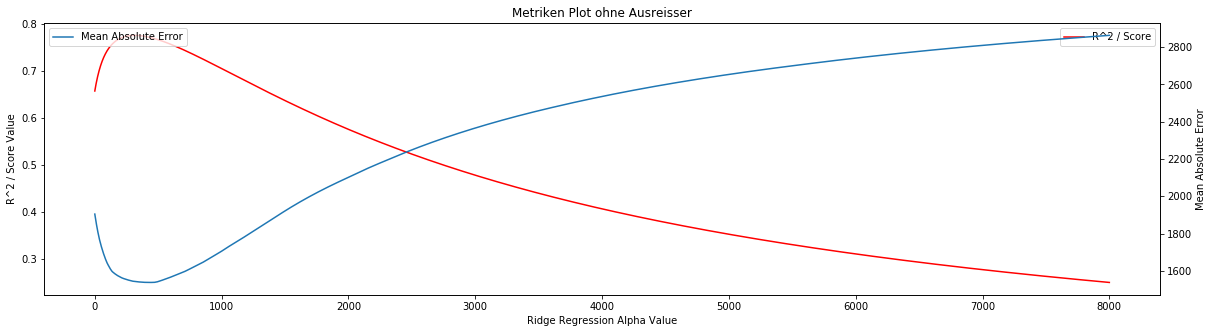

R^2/Score max value: 0.7754687864919412
Alpha value for R^2/Score max value: 314.01570078503926

Mean Absolute Error min value: 1537.653855025291
Alpha value for Mean Absolute Error min value: 420.0210010500525

Mean Absolute Error where R^2 is max 1606.8815768474167
R^2/Score value where MAE is minimum: 0.763992809272986


In [42]:
pca_data = data_no_outliers[['bmi', 'pbf']]

X = pca_data.values
X = X.T
x_mean = X - np.mean(X, axis=0) 

test = np.cov(x_mean)
(eigvalues_, components_) = np.linalg.eigh(test)
print(components_.T)
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

data4 = data_no_outliers.copy()
data4[['bmi', 'pbf']] = np.dot(data4[['bmi', 'pbf']].values, components_.T)

labels = np.array(data_no_outliers['charges'])

# The data we want to split = 'input'
input = data4.drop('sex', axis=1).drop('charges', axis = 1).drop('charges_level', axis = 1)

# The argument for the split function has to be an array
input = np.array(input)

alphaRange = np.linspace(0, 8000, 20000)

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.1, random_state = 42) 
train_input = np.array(train_input, dtype=np.float64)
test_input = np.array(test_input, dtype=np.float64)

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

scoreArray = []
maeArray = []

for j in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = j)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)

plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

In [43]:
RidgeRegressor = RidgeRegression(opt_method='neq', alpha = 375)
ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

predics = RidgeRegressor.predict(test_input_standardize)

test = test_input_standardize
print("Input Data: ", test[10:16:])
print("Real Charges: ", test_labels[10:16:])
print("Predicted Charges: ", predics[10:16:])

Input Data:  [[-8.36635374e-01  3.34777756e-01  7.66975774e-01 -2.03809866e+00
  -1.25827403e+00 -9.16107545e-01]
 [ 3.88995097e-01 -1.27452635e+00  7.66975774e-01  4.90653381e-01
   1.33570628e+00  1.29992281e+00]
 [-4.04059914e-01  1.44038629e-01 -8.24023559e-02 -2.03809866e+00
   1.33570628e+00 -7.23361256e-01]
 [-1.34130674e+00  1.43221502e+00 -8.24023559e-02  4.90653381e-01
   4.71046174e-01 -1.46961836e+00]
 [-3.31964004e-01 -1.09543841e+00  3.31511016e+00  4.90653381e-01
  -1.25827403e+00 -1.81993674e-01]
 [-6.20347644e-01  1.60611727e-03 -9.31780486e-01 -2.03809866e+00
  -1.25827403e+00 -6.19150205e-01]]
Real Charges:  [ 6556  7737 10859  2298  7658  9845]
Predicted Charges:  [ 9664.74480847  9073.54860368 11180.74190152   465.10124784
  7727.28267729 10406.59849367]


With PCA of the biggest influencer of charges (age, smoker (Y/N), pbf, bmi) the MAE comes down is reduced to 831 and the score is actually over .9

[[-0.57735027 -0.57735027 -0.57735027]
 [-0.57533275  0.78940751 -0.21407476]
 [-0.57936076 -0.2085724   0.78793316]]


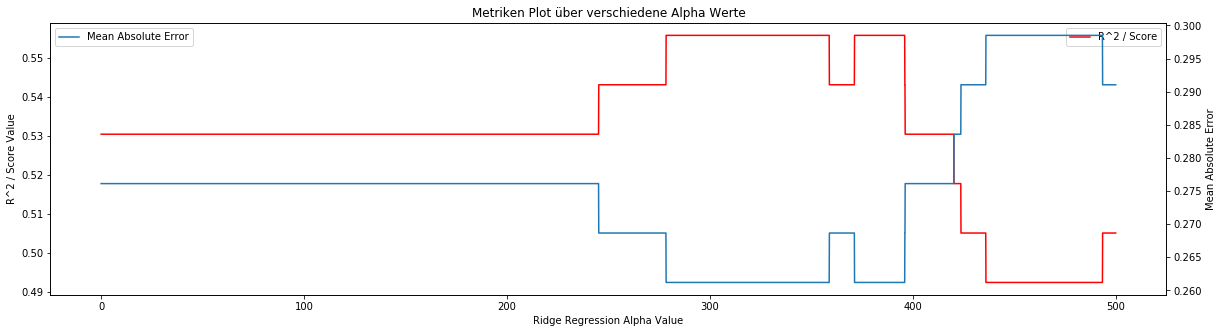

R^2/Score max value: 0.5558712121212122
Alpha value for R^2/Score max value: 278.3778377837784

Mean Absolute Error min value: 0.26119402985074625
Alpha value for Mean Absolute Error min value: 278.3778377837784

Mean Absolute Error where R^2 is max 0.27611940298507465
R^2/Score value where MAE is minimum: 0.5304924242424243


In [46]:
pca_data = data_no_outliers[['sex','bmi', 'pbf']]

X = pca_data.values
X = X.T
x_mean = X - np.mean(X, axis=0) 

test = np.cov(x_mean)
(eigvalues_, components_) = np.linalg.eigh(test)
print(components_.T)
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

data4 = data_no_outliers.copy()
data4[['sex','bmi', 'pbf']] = np.dot(data4[['sex', 'bmi', 'pbf']].values, components_.T)

labels = np.array(data_no_outliers['charges'])

# The data we want to split = 'input'
input = data4.drop('sex', axis=1).drop('charges', axis = 1).drop('charges_level', axis = 1)

# The argument for the split function has to be an array
input = np.array(input)

alphaRange = np.linspace(0, 8000, 20000)

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.1, random_state = 42) 
train_input = np.array(train_input, dtype=np.float64)
test_input = np.array(test_input, dtype=np.float64)

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 500, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)
    predics = RidgeRegressor.predict(test_input_standardize)
    
    #print(predics[:20])
    bins = [0, 5000, 10000, 20000, 100000]
    predics_categorized = pd.cut(abs(predics), bins=bins, labels=bin_labels, include_lowest=True)
    test_labels_categorized = pd.cut(abs(test_labels), bins=bins, labels=bin_labels, include_lowest=True)
    
    
    #print(predics_categorized.to_numpy(), test_labels_categorized.to_numpy())
    
    
    score = RidgeRegressor.score(test_labels_categorized.to_numpy(), predics_categorized.to_numpy())
    mae = RidgeRegressor.mae(test_labels_categorized.to_numpy(), predics_categorized.to_numpy())
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

In [28]:
# YOUR CODE HERE
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn

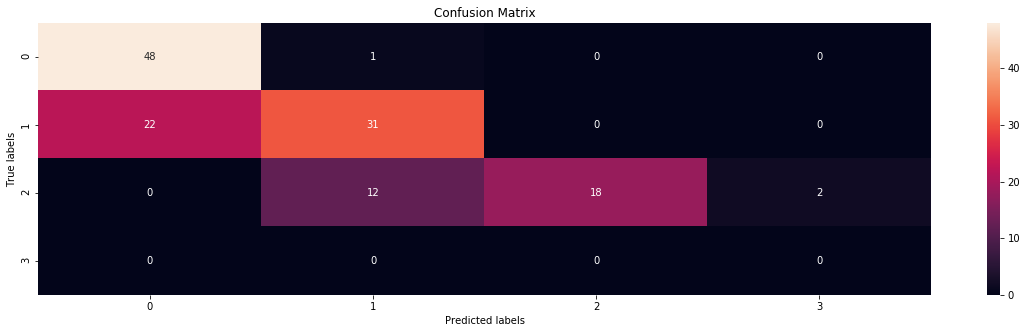

              precision    recall  f1-score   support

           0       0.98      0.69      0.81        70
           1       0.58      0.70      0.64        44
           2       0.56      1.00      0.72        18
           3       0.00      0.00      0.00         2

    accuracy                           0.72       134
   macro avg       0.53      0.60      0.54       134
weighted avg       0.78      0.72      0.73       134



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
RidgeRegressor = RidgeRegression(opt_method='neq', alpha = 129)
ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

predics = RidgeRegressor.predict(test_input_standardize)

bins = [0, 5000, 10000, 20000, 100000]

predics_categorized = pd.cut(abs(predics), bins=bins, labels=bin_labels, include_lowest=True)
test_labels_categorized = pd.cut(abs(test_labels), bins=bins, labels=bin_labels, include_lowest=True)


cm = confusion_matrix(predics_categorized, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

#logistic_regression.score(X_test, y_test)
#plot_confusion_matrix(logistic_regression, X_test, y_test, display_labels = y_labels)
print(classification_report(test_labels_categorized, predics_categorized))

[0, 3, 1, 0, 1, ..., 1, 0, 0, 0, 1]
Length: 1199
Categories (4, int64): [0 < 1 < 2 < 3]


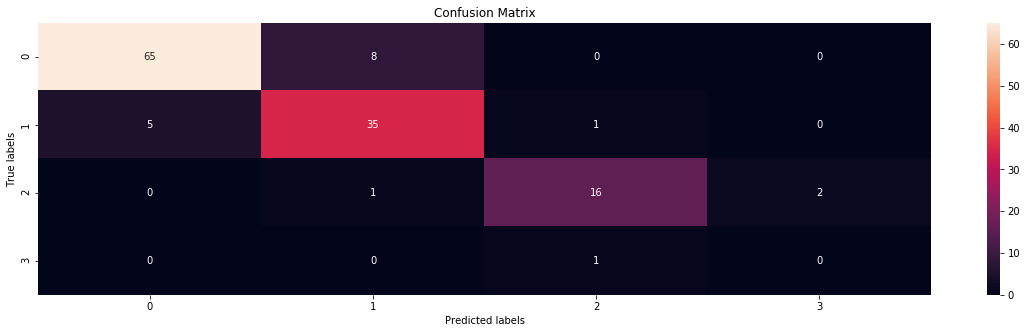

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        70
           1       0.85      0.80      0.82        44
           2       0.84      0.89      0.86        18
           3       0.00      0.00      0.00         2

    accuracy                           0.87       134
   macro avg       0.65      0.65      0.65       134
weighted avg       0.86      0.87      0.86       134



In [30]:
scaler = preprocessing.StandardScaler().fit(train_input_standardize)
X_scaled = scaler.transform(train_input_standardize)

logistic_regression = LogisticRegression(max_iter = 100)
train_labels_categorized = pd.cut(abs(train_labels), bins=bins, labels=bin_labels, include_lowest=True)
logistic_regression.fit(X_scaled, train_labels_categorized)
print(train_labels_categorized)
label_prediction = logistic_regression.predict(test_input_standardize)
cm = confusion_matrix(label_prediction, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

print(classification_report(test_labels_categorized, label_prediction))

## TODO?

- Backwards/Forwards Selection
- ✓ (for alpha) Metrics
- Check factorization?
- ✓ (just the children outliers and the extremely high bmi for 20 years odl) Check outliers
- ✓ Logarithms?
- ✓ (For the biggest influencer of charges) Orthogonalization using PCA?
- Polynomials?
- Se
- ✓ (For smoker it's much more accurate) Aufteilung in mehrere regression pro raucherklassen

After first deep dive TODO:
- PCA for more split up categories like in example for smokers